In [1]:
# Import Libraries
import pandas as pd
import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
import pyreadr
import numpy as np

# set the plotting style
sns.set_style("whitegrid")

# Train-test splits
from sklearn.model_selection import train_test_split

#Model preprocessing
from sklearn import preprocessing

# Models
from sklearn.linear_model import LinearRegression
import statsmodels.api as sm
from sklearn.neural_network import MLPRegressor
from sklearn.preprocessing import StandardScaler

# PCA
from sklearn.decomposition import PCA

# Model metrics
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Time Series Analysis
import statsmodels.api as sm
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [2]:
# Read the data from .RDS files
import pyreadr
data =  pyreadr.read_r('2019_1min_df.RDS')
df_2019 = data[None]
data = pyreadr.read_r('2020_1min_df.RDS')
df_2020 = data[None]
data = pyreadr.read_r('2021_1min_df.RDS')
df_2021 = data[None]
data = pyreadr.read_r('2022_1min_df.RDS')
df_2022 = data[None]
data = pyreadr.read_r('2023_1min_df.RDS')
df_2023 = data[None]

# Merge all the dataframes to form one dataframe.
df = pd.concat([df_2019, df_2020, df_2021, df_2022, df_2023], ignore_index=True)
df.shape

(2629440, 10)

Calculations:
Tasks: Start by calculating inflow by logic in inflow text file - see how it compares to headwater and discharge at the dam is increasing or decreasing

In [3]:
# Fillna
df.fillna(method = 'ffill', inplace = True)
df.fillna(method = 'bfill',inplace = True)
df.head()

,datetime_utc,datetime_stamp,Wells_Total_Discharge,Chelan_Flow,Entiat_Flow,Rocky_Reach_Total_Discharge,Wenatchee_Flow,Rock_Island_Total_Discharge,Rock_Island_Headwater_Elevation,Rocky_Reach_Headwater_Elevation
0,2019-01-01T08:00:00Z,2019-01-01 08:00:00,64.991571,2.387225,0.0,72.286020,1.823813,95.571837,612.805419,705.512061
1,2019-01-01T08:01:00Z,2019-01-01 08:01:00,59.312555,2.387256,0.0,68.821629,1.823704,95.675746,612.793892,705.510341
2,2019-01-01T08:02:00Z,2019-01-01 08:02:00,51.471802,2.387287,0.0,66.502634,1.823594,94.028171,612.812751,705.515385
3,2019-01-01T08:03:00Z,2019-01-01 08:03:00,54.252264,2.387319,0.0,63.876623,1.823484,93.075551,612.836556,705.546697
4,2019-01-01T08:04:00Z,2019-01-01 08:04:00,55.120167,2.387350,0.0,62.371067,1.823375,93.617712,612.834370,705.581749


In [4]:
df.isna().sum()

datetime_utc                       0
datetime_stamp                     0
Wells_Total_Discharge              0
Chelan_Flow                        0
Entiat_Flow                        0
Rocky_Reach_Total_Discharge        0
Wenatchee_Flow                     0
Rock_Island_Total_Discharge        0
Rock_Island_Headwater_Elevation    0
Rocky_Reach_Headwater_Elevation    0
dtype: int64

In [5]:
# Converting 'datetime_utc' to datetime format
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])

# Wells Flow Impact (flows averaged from previous 90-105 minutes)
df['Wells_Flow_Impact'] = df['Wells_Total_Discharge'].shift(105).rolling(window=16).mean()
df['Wells_Flow_Impact'].fillna(method='bfill', inplace=True)

# Chelan Flow Impact (flows averaged from previous 60-77 minutes)
df['Chelan_Flow_Impact'] = df['Chelan_Flow'].shift(77).rolling(window=16).mean()
df['Chelan_Flow_Impact'].fillna(method='bfill', inplace=True)

# Entiat Flow Impact (flows averaged from previous 15-30 minutes)
df['Entiat_Flow_Impact'] = df['Entiat_Flow'].shift(30).rolling(window=16).mean()
df['Entiat_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate Rocky Reach Inflow
df['Rocky_Reach_Inflow'] = df['Wells_Flow_Impact'] + df['Chelan_Flow_Impact'] + df['Entiat_Flow_Impact']

In [6]:
# Define the conditions and corresponding shifts
conditions = [50, 80, 120, 150, 220]
shifts = [43, 45, 47, 48, 50]

# Calculate 'Rocky_Reach_Flow_Impact' in a vectorized way
df['Rocky_Reach_Flow_Impact'] = np.select(
    [df['Rocky_Reach_Total_Discharge'] <= condition for condition in conditions],
    [df['Rocky_Reach_Total_Discharge'].shift(shift) for shift in shifts],
    default=df['Rocky_Reach_Total_Discharge'].shift(50)
)
# For starting rows
df['Rocky_Reach_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate 'Wenatchee_Flow_Impact' with backward filling
df['Wenatchee_Flow_Impact'] = df['Wenatchee_Flow'].shift(22)
# For starting rows
df['Wenatchee_Flow_Impact'].fillna(method='bfill', inplace=True)

# Calculate 'Rock Island Inflow'
df['Rock_Island_Inflow'] = df['Rocky_Reach_Flow_Impact'] + df['Wenatchee_Flow_Impact']

In [7]:
# Calculate fill rate at both dams
df['Rocky_Reach_Fill_Rate'] = df['Rocky_Reach_Inflow'] - df['Rocky_Reach_Total_Discharge']
df['Rock_Island_Fill_Rate'] = df['Rock_Island_Inflow'] - df['Rock_Island_Total_Discharge']

# Display the updated DataFrame
df[['Rocky_Reach_Fill_Rate','Rock_Island_Fill_Rate']].head()

,Rocky_Reach_Fill_Rate,Rock_Island_Fill_Rate
0,-13.758636,-21.462003
1,-10.294244,-21.565912
2,-7.975250,-19.918337
3,-5.349238,-18.965717
4,-3.843683,-19.507878


In [8]:
# Calculate the change in Rocky Reach headwater elevation
df['Rocky_Reach_Headwater_Elevation_Change'] = df['Rocky_Reach_Headwater_Elevation'].diff()
df['Rocky_Reach_Headwater_Elevation_Change'].fillna(method='ffill', inplace=True)
df['Rocky_Reach_Headwater_Elevation_Change'].fillna(method='bfill', inplace=True)

In [9]:
# Calculate the change in Rock island headwater elevation
df['Rock_Island_Headwater_Elevation_Change'] = df['Rock_Island_Headwater_Elevation'].diff()
df['Rock_Island_Headwater_Elevation_Change'].fillna(method='ffill', inplace=True)
df['Rock_Island_Headwater_Elevation_Change'].fillna(method='bfill', inplace=True)

In [10]:
df.head()

,datetime_utc,datetime_stamp,Wells_Total_Discharge,Chelan_Flow,Entiat_Flow,Rocky_Reach_Total_Discharge,Wenatchee_Flow,Rock_Island_Total_Discharge,Rock_Island_Headwater_Elevation,Rocky_Reach_Headwater_Elevation,...,Chelan_Flow_Impact,Entiat_Flow_Impact,Rocky_Reach_Inflow,Rocky_Reach_Flow_Impact,Wenatchee_Flow_Impact,Rock_Island_Inflow,Rocky_Reach_Fill_Rate,Rock_Island_Fill_Rate,Rocky_Reach_Headwater_Elevation_Change,Rock_Island_Headwater_Elevation_Change
0,2019-01-01 08:00:00+00:00,2019-01-01 08:00:00,64.991571,2.387225,0.0,72.286020,1.823813,95.571837,612.805419,705.512061,...,2.387459,0.0,58.527385,72.28602,1.823813,74.109834,-13.758636,-21.462003,-0.001719,-0.011527
1,2019-01-01 08:01:00+00:00,2019-01-01 08:01:00,59.312555,2.387256,0.0,68.821629,1.823704,95.675746,612.793892,705.510341,...,2.387459,0.0,58.527385,72.28602,1.823813,74.109834,-10.294244,-21.565912,-0.001719,-0.011527
2,2019-01-01 08:02:00+00:00,2019-01-01 08:02:00,51.471802,2.387287,0.0,66.502634,1.823594,94.028171,612.812751,705.515385,...,2.387459,0.0,58.527385,72.28602,1.823813,74.109834,-7.975250,-19.918337,0.005044,0.018859
3,2019-01-01 08:03:00+00:00,2019-01-01 08:03:00,54.252264,2.387319,0.0,63.876623,1.823484,93.075551,612.836556,705.546697,...,2.387459,0.0,58.527385,72.28602,1.823813,74.109834,-5.349238,-18.965717,0.031312,0.023805
4,2019-01-01 08:04:00+00:00,2019-01-01 08:04:00,55.120167,2.387350,0.0,62.371067,1.823375,93.617712,612.834370,705.581749,...,2.387459,0.0,58.527385,72.28602,1.823813,74.109834,-3.843683,-19.507878,0.035052,-0.002186


## Time Series Modeleing on 30 minute Intervals:


In [11]:
# 30 minute intervals:
df['datetime_utc'] = pd.to_datetime(df['datetime_utc'])
# Set datetime as the index
df.set_index('datetime_utc', inplace=True)
# Resample the data into 30-minute intervals and calculate the mean
df_resampled = df.resample('30T').mean()

# Reset index to have datetime_utc as a regular column
df_resampled.reset_index(inplace=True)


In [12]:
df_resampled.head()

,datetime_utc,Wells_Total_Discharge,Chelan_Flow,Entiat_Flow,Rocky_Reach_Total_Discharge,Wenatchee_Flow,Rock_Island_Total_Discharge,Rock_Island_Headwater_Elevation,Rocky_Reach_Headwater_Elevation,Wells_Flow_Impact,Chelan_Flow_Impact,Entiat_Flow_Impact,Rocky_Reach_Inflow,Rocky_Reach_Flow_Impact,Wenatchee_Flow_Impact,Rock_Island_Inflow,Rocky_Reach_Fill_Rate,Rock_Island_Fill_Rate,Rocky_Reach_Headwater_Elevation_Change,Rock_Island_Headwater_Elevation_Change
0,2019-01-01 08:00:00+00:00,56.131330,2.387677,0.0,60.520830,1.822119,90.628069,612.815965,705.555262,56.139926,2.387459,0.0,58.527385,72.286020,1.823711,74.109731,-1.993445,-16.518337,0.003113,-0.000622
1,2019-01-01 08:30:00+00:00,55.433639,2.388613,0.0,52.634011,1.818484,78.723236,612.801513,705.628792,56.139926,2.387459,0.0,58.527385,67.723416,1.821157,69.544572,5.893373,-9.178664,0.001700,-0.001349
2,2019-01-01 09:00:00+00:00,58.328788,2.389549,0.0,40.262839,1.814839,55.801906,612.827773,705.751023,56.139926,2.387459,0.0,58.527385,56.116463,1.817512,57.933974,18.264546,2.132069,0.002475,0.003326
3,2019-01-01 09:30:00+00:00,58.106455,2.390484,0.0,48.422503,1.811194,45.582562,612.795606,705.648621,56.139926,2.387852,0.0,58.527778,44.228276,1.813867,46.042142,10.105274,0.459580,-0.004288,-0.002440
4,2019-01-01 10:00:00+00:00,58.851311,2.391420,0.0,54.805165,1.807549,31.037409,612.778841,705.591932,55.700151,2.388784,0.0,58.088936,43.445364,1.810222,45.255586,3.283771,14.218177,-0.000106,0.003774


## Rocky Reach:

C:\Users\aqdca\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


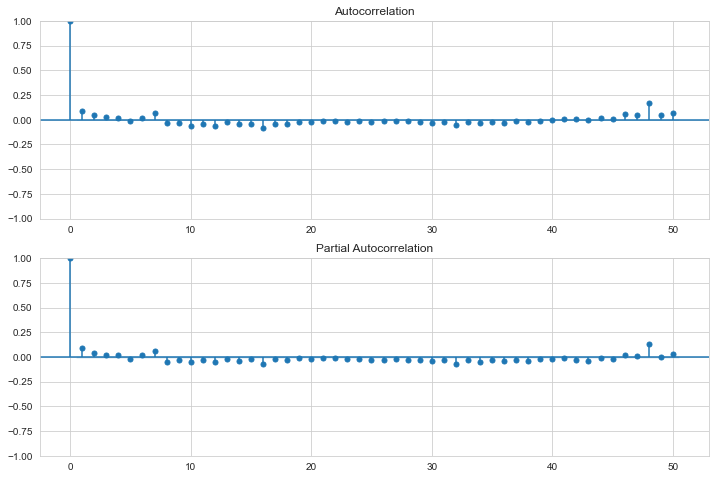

In [13]:
# Convert index to datetime if it's not already
df_resampled.index = pd.to_datetime(df_resampled.index)

# Plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_resampled['Rocky_Reach_Headwater_Elevation_Change'], lags=50, ax=ax[0])
plot_pacf(df_resampled['Rocky_Reach_Headwater_Elevation_Change'], lags=50, ax=ax[1])
plt.show()

These plots show that lag 1 and 7 have a positive correlation. Also at lag 48

### Summer and Fall months on 30 minute Intervals:


In [14]:
# Convert the 'datetime_utc' column to datetime type
df_resampled['datetime_utc'] = pd.to_datetime(df_resampled['datetime_utc'])

# Filter the dataframe to include only the summer (June, July, August) and fall (September, October, November) months
summer_fall_data = df_resampled[df_resampled['datetime_utc'].dt.month.isin([6, 7, 8, 9, 10, 11])]

In [21]:
# Reset the index of the summer_fall_data dataframe
#summer_fall_data.reset_index(drop=True, inplace=True)
# Set datetime as the index
summer_fall_data.set_index('datetime_utc', inplace=True)
summer_fall_data.head()

,Wells_Total_Discharge,Chelan_Flow,Entiat_Flow,Rocky_Reach_Total_Discharge,Wenatchee_Flow,Rock_Island_Total_Discharge,Rock_Island_Headwater_Elevation,Rocky_Reach_Headwater_Elevation,Wells_Flow_Impact,Chelan_Flow_Impact,Entiat_Flow_Impact,Rocky_Reach_Inflow,Rocky_Reach_Flow_Impact,Wenatchee_Flow_Impact,Rock_Island_Inflow,Rocky_Reach_Fill_Rate,Rock_Island_Fill_Rate,Rocky_Reach_Headwater_Elevation_Change,Rock_Island_Headwater_Elevation_Change
datetime_utc,,,,,,,,,,,,,,,,,,,
2019-06-01 00:00:00+00:00,168.090574,2.36182,1.55,192.334977,8.940170,156.092727,612.701796,706.774360,173.664322,2.363594,1.550024,177.577939,150.275231,8.945403,159.220634,-14.757037,3.127907,-0.003045,0.005392
2019-06-01 00:30:00+00:00,170.560446,2.36119,1.55,202.390102,8.933033,173.006125,612.784344,706.645458,181.404009,2.362964,1.550000,185.316973,174.804020,8.938267,183.742287,-17.073130,10.736161,-0.005469,-0.000035
2019-06-01 01:00:00+00:00,163.370972,2.36056,1.55,189.281857,8.925896,186.736796,612.864394,706.611837,174.369415,2.362334,1.550000,178.281749,197.493609,8.931130,206.424739,-11.000108,19.687943,0.000906,0.003732
2019-06-01 01:30:00+00:00,169.560689,2.35993,1.55,161.853815,8.918759,196.190118,612.886422,706.732852,169.041357,2.361704,1.550000,172.953062,201.303067,8.923993,210.227060,11.099247,14.036942,0.003937,-0.003944
2019-06-01 02:00:00+00:00,167.661584,2.35930,1.55,147.805813,8.911623,192.547150,612.712665,706.837623,168.929968,2.361075,1.550000,172.841043,178.883923,8.916856,187.800779,25.035230,-4.746371,0.004566,-0.003317


In [22]:
# Split the Data into Training and Testing Sets
train_size = int(len(summer_fall_data) * 0.8)  # 80% for training
train_data, test_data = summer_fall_data.iloc[:train_size], summer_fall_data.iloc[train_size:]

In [23]:
# Fit SARIMA Model
seasonal_order = (1, 0, 1, 24)  
model_sarima = SARIMAX(train_data['Rocky_Reach_Headwater_Elevation_Change'], order=(1, 0, 1), seasonal_order=seasonal_order)
results_sarima = model_sarima.fit()
# Model Diagnostic Checking
print(results_sarima.summary())

C:\Users\aqdca\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aqdca\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                         SARIMAX Results                                          
Dep. Variable:     Rocky_Reach_Headwater_Elevation_Change   No. Observations:                35136
Model:                     SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              135239.932
Date:                                    Wed, 06 Mar 2024   AIC                        -270469.863
Time:                                            21:47:08   BIC                        -270427.528
Sample:                                                 0   HQIC                       -270456.381
                                                  - 35136                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.8152      0.017     48.561      0

Coefficients:

ar.L1: Coefficient for the autoregressive (AR) term at lag 1. In this case, it is 0.8152.
ma.L1: Coefficient for the moving average (MA) term at lag 1. In this case, it is -0.7510.
ar.S.L24: Coefficient for the seasonal AR term at lag 24 (1 day). In this case, it is -0.0048.
ma.S.L24: Coefficient for the seasonal MA term at lag 24 (1 day). In this case, it is -0.0096.
sigma2: The estimated variance of the residuals (error term) from the model. Lower values indicate less variance around the model's predictions.



C:\Users\aqdca\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean Squared Error: 4.0231715410714706e-05
R-squared: 3.510564870834454e-05


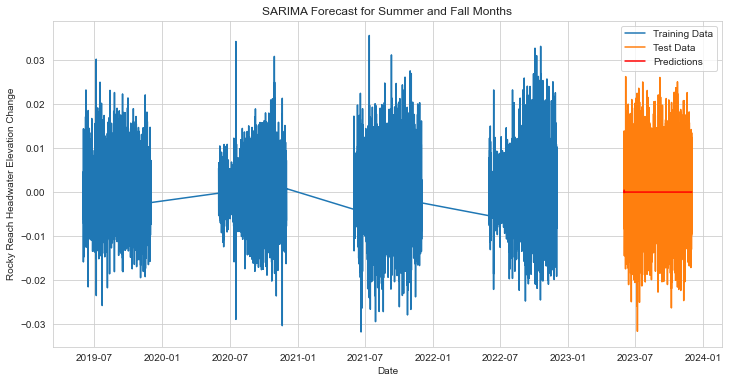

In [24]:
# Make Predictions
predictions = results_sarima.forecast(len(test_data))

# Evaluate the Model
mse = mean_squared_error(test_data['Rocky_Reach_Headwater_Elevation_Change'], predictions)
r_squared = r2_score(test_data['Rocky_Reach_Headwater_Elevation_Change'], predictions)
print('Mean Squared Error:', mse)
print('R-squared:', r_squared)

#  Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Rocky_Reach_Headwater_Elevation_Change'], label='Training Data')
plt.plot(test_data.index, test_data['Rocky_Reach_Headwater_Elevation_Change'], label='Test Data')
plt.plot(test_data.index, predictions, color='red', label='Predictions')
plt.xlabel('Date')
plt.ylabel('Rocky Reach Headwater Elevation Change')
plt.title('SARIMA Forecast for Summer and Fall Months')
plt.legend()
plt.show()

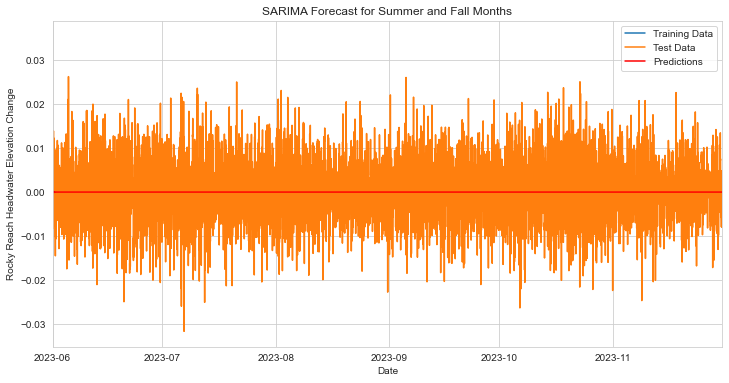

In [29]:
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Rocky_Reach_Headwater_Elevation_Change'], label='Training Data')
plt.plot(test_data.index, test_data['Rocky_Reach_Headwater_Elevation_Change'], label='Test Data')
plt.plot(test_data.index, predictions, color='red', label='Predictions')
plt.xlabel('Date')
plt.ylabel('Rocky Reach Headwater Elevation Change')
plt.title('SARIMA Forecast for Summer and Fall Months')
plt.legend()

#Focusing on predicted forecast
start_date = test_data.index[0]  
end_date = test_data.index[-1]   
plt.xlim(start_date, end_date)   # Set x-axis limits

plt.show()

## Rock Island:

C:\Users\aqdca\anaconda3\lib\site-packages\statsmodels\graphics\tsaplots.py:348: FutureWarning: The default method 'yw' can produce PACF values outside of the [-1,1] interval. After 0.13, the default will change tounadjusted Yule-Walker ('ywm'). You can use this method now by setting method='ywm'.
  warnings.warn(


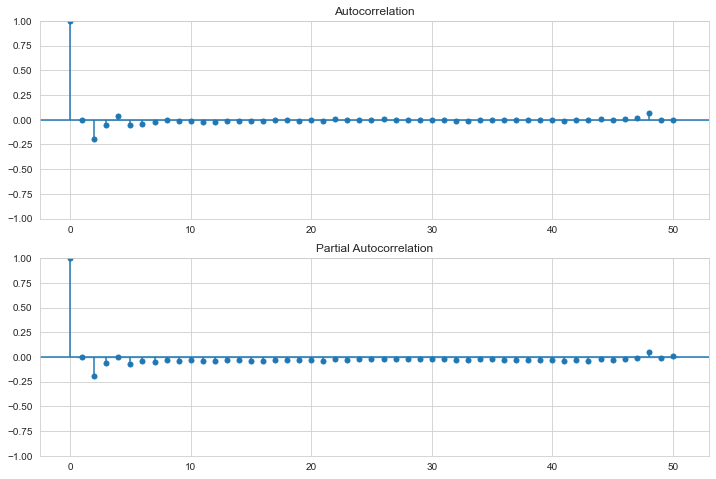

In [19]:
# Plot autocorrelation and partial autocorrelation
fig, ax = plt.subplots(2, 1, figsize=(12, 8))
plot_acf(df_resampled['Rock_Island_Headwater_Elevation_Change'], lags=50, ax=ax[0])
plot_pacf(df_resampled['Rock_Island_Headwater_Elevation_Change'], lags=50, ax=ax[1])
plt.show()

There is strong correlation between an obeservarion and its immediate previous observation as shown in the ACF. This also suggests that there is a seasonality trend. Lag 2 shows that there is a negative correlation between an obseration and the observation 2 time periods ago. This suggests that there might be some periodic behavior or cyclical pattern in the data.

In [25]:
# Fit SARIMA Model: Define the seasonal order based on the seasonality of your data (e.g., daily seasonality)
seasonal_order = (1, 0, 1, 24)  # Example seasonal order, adjust as needed
model_sarima = SARIMAX(train_data['Rock_Island_Headwater_Elevation_Change'], order=(1, 0, 1), seasonal_order=seasonal_order)
results_sarima = model_sarima.fit()
# Model Diagnostic Checking
print(results_sarima.summary())

C:\Users\aqdca\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\aqdca\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:471: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)


                                         SARIMAX Results                                          
Dep. Variable:     Rock_Island_Headwater_Elevation_Change   No. Observations:                35136
Model:                     SARIMAX(1, 0, 1)x(1, 0, 1, 24)   Log Likelihood              125071.734
Date:                                    Wed, 06 Mar 2024   AIC                        -250133.467
Time:                                            21:47:51   BIC                        -250091.132
Sample:                                                 0   HQIC                       -250119.985
                                                  - 35136                                         
Covariance Type:                                      opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.3585      0.116      3.101      0

C:\Users\aqdca\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:834: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(


Mean Squared Error: 6.209750219390395e-05
R-squared: 8.345743714999188e-07


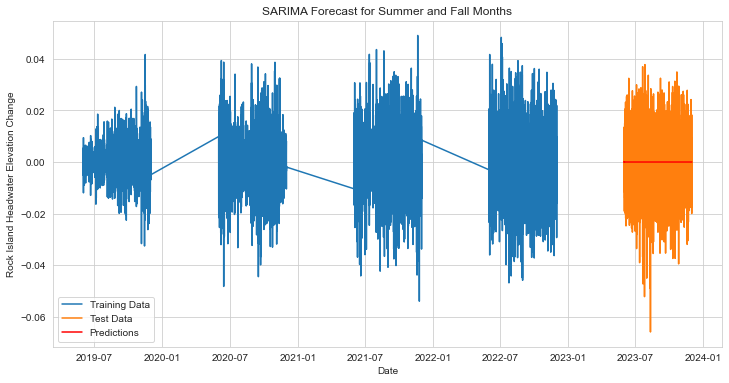

In [27]:
# Make Predictions
predictions = results_sarima.forecast(len(test_data))

# Evaluate the Model
mse = mean_squared_error(test_data['Rock_Island_Headwater_Elevation_Change'], predictions)
print('Mean Squared Error:', mse)
r_squared = r2_score(test_data['Rock_Island_Headwater_Elevation_Change'], predictions)
print('R-squared:', r_squared)


#  Plot the Results
plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Rock_Island_Headwater_Elevation_Change'], label='Training Data')
plt.plot(test_data.index, test_data['Rock_Island_Headwater_Elevation_Change'], label='Test Data')
plt.plot(test_data.index, predictions, color='red', label='Predictions')
plt.xlabel('Date')
plt.ylabel('Rock Island Headwater Elevation Change')
plt.title('SARIMA Forecast for Summer and Fall Months')
plt.legend()
plt.show()

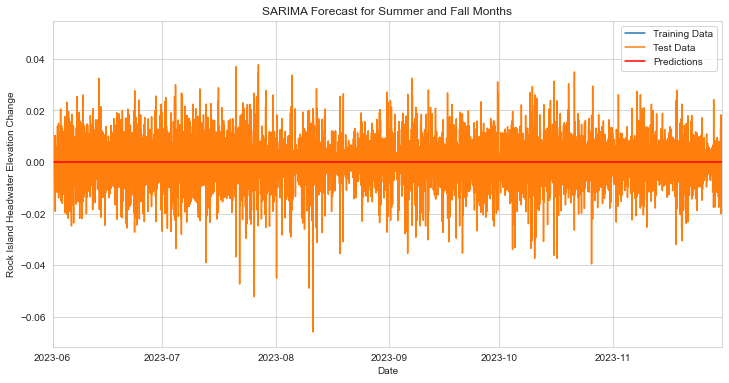

In [28]:

plt.figure(figsize=(12, 6))
plt.plot(train_data.index, train_data['Rock_Island_Headwater_Elevation_Change'], label='Training Data')
plt.plot(test_data.index, test_data['Rock_Island_Headwater_Elevation_Change'], label='Test Data')
plt.plot(test_data.index, predictions, color='red', label='Predictions')
plt.xlabel('Date')
plt.ylabel('Rock Island Headwater Elevation Change')
plt.title('SARIMA Forecast for Summer and Fall Months')
plt.legend()

#Focusing on predicted forecast
start_date = test_data.index[0]  
end_date = test_data.index[-1]   
plt.xlim(start_date, end_date)   # Set x-axis limits

plt.show()